In [36]:
import numpy as np
import random
import matplotlib.pyplot as plt

MAX_DEPTH = 20
PROB_BRANCH = 0.25
VALUES = range(1, 10)
OPS_E = [0, 1]
OPS_T = [2, 3]
NTYPES = ['e', 't']
OP_MAP = ['+', '-', '*', '/']

# functions

In [37]:
def gen_expr(depth, ntype):

    if depth < MAX_DEPTH:
        r = random.random()
    else:
        r = 1

    if r > PROB_BRANCH:
        if ntype == 'f':
            value = random.choice(VALUES)
            return value
        elif ntype == 't':
            return gen_expr(depth + 1, 'f')
        elif ntype == 'e':
            return gen_expr(depth + 1, 't')

    else:
        if ntype == 'e':
            op = random.choice(OPS_E)
            v1, v2 = gen_expr(depth + 2, 'e'), gen_expr(depth + 1, 't')
            t = ((v1, OP_MAP[op]), v2)
        elif ntype == 't':
            op = random.choice(OPS_T)
            v1, v2 = gen_expr(depth + 2, 't'), gen_expr(depth + 1, 'f')
            t = ((v1, OP_MAP[op]), v2)
        else:
            t = gen_expr(depth + 1, 'f')

    return t

In [38]:
def gen_tree():
    return gen_expr(0, 'e')

In [48]:
PROB_BRANCH = 0.8
gen_tree()

((((((((((((((((((((2, '+'), 8), '-'), ((((5, '*'), 9), '/'), 3)), '-'),
               ((((((9, '/'), 7), '/'), 1), '/'), 4)),
              '-'),
             ((((((((9, '*'), 8), '/'), 4), '*'), 9), '*'), 2)),
            '-'),
           ((((((((((9, '/'), 2), '*'), 8), '/'), 4), '*'), 3), '/'), 5)),
          '+'),
         ((((((((((((3, '/'), 4), '*'), 2), '/'), 9), '/'), 7), '*'), 2), '/'),
          3)),
        '+'),
       ((4, '*'), 3)),
      '+'),
     ((((((((((((7, '/'), 7), '*'), 4), '*'), 8), '/'), 5), '*'), 6), '*'),
      2)),
    '+'),
   ((9, '/'), 4)),
  '+'),
 ((((8, '*'), 4), '*'), 8))

In [77]:
def to_value(t):
    if not isinstance(t, tuple):
        return t

    l = t[0]
    r = t[1]
    v1, op = (to_value(l[0]), l[1])
    v2 = to_value(r)

    return eval(''.join([str(v1), op, str(v2)]))

In [78]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = (child_l, child_r)
        if isinstance(v_l, tuple) and not isinstance(v_r, tuple):
            v1, op = v_l[0], v_l[1]
            v2 = v_r
            v = str(eval(''.join([v1, op, v2])))
        else:
            assert not isinstance(v_l, tuple) and not isinstance(v_r, tuple)
            v = (v_l, v_r)

    return node, v

In [79]:
def to_sd(t):
    if not isinstance(t, tuple):
        d = []
        h = 0
    else:
        l, r = t
        d_l, h_l = to_sd(l)
        d_r, h_r = to_sd(r)
        h = max(h_l, h_r) + 1
        d = d_l + [h] + d_r

    return d, h


In [80]:
def to_nlst(t):
    return list(filter(lambda x: x not in ['(', ')', ',', '\'', ' '], str(t)))

# check for syntax of trees

In [45]:
MAX_DEPTH = 30
for _ in range(100000):
    expr = gen_expr(0, 'e')
    if expr in VALUES:
        continue

    if expr not in VALUES:
        res = list(filter(lambda x: x not in ['(',')', ',', '\'', ' '], str(expr)))
        gold = eval(''.join(res))
        calc = to_value(expr)
        if gold != calc:
            print(expr, calc, gold)

# check for syntatic distance

In [49]:
MAX_DEPTH = 30
for _ in range(100000):
    expr = gen_expr(0, 'e')
    if expr in VALUES:
        continue

    if expr not in VALUES:
        node_lst = to_nlst(expr)
        sd_lst, h = to_sd(expr)
        gold = eval(''.join(node_lst))
        t, calc = to_value_sd(sd_lst, node_lst)
        if str(gold) != calc:
            print(expr, calc, gold)

# examples

In [58]:
MAX_DEPTH = 30
for _ in range(5):
    expr = gen_tree()
    if expr in VALUES:
        continue
        
    sd_lst, h = to_sd(expr)
    print(expr)
    print(sd_lst)

((((6, '/'), 1), '-'), 2)
[1, 2, 3, 4]
((((7, '/'), 2), '+'), ((3, '*'), 2))
[1, 2, 3, 4, 1, 2]


In [56]:
expr = ((((((6, '*'), 5), '+'), 7), '+'), ((1, '/'), 9))
print(expr)
sd_lst, _ = to_sd(expr)
print(sd_lst)
node_lst = to_nlst(expr)
print(node_lst)
node, val = to_value_sd(sd_lst, node_lst)
print(node)
print(val)

((((((6, '*'), 5), '+'), 7), '+'), ((1, '/'), 9))
[1, 2, 3, 4, 5, 6, 1, 2]
['6', '*', '5', '+', '7', '+', '1', '/', '9']
(((((('6', '*'), '5'), '+'), '7'), '+'), (('1', '/'), '9'))
37.111111111111114


# generate dataset

In [289]:
from collections import defaultdict

MAX_DEPTH = 30
PROB_BRANCH = 0.6
NSAMPLES = 100000
# NSAMPLES = 1000
prob_h = (1/np.array(range(2, MAX_DEPTH+1)) )**(1.5)
prob_h = prob_h / prob_h.sum()
nsamples_bound = {h:int(prob_h[h-2]*NSAMPLES) for h in range(2, MAX_DEPTH+1)}
nsamples = defaultdict(int)

In [290]:
examples = []
printed = {h:False for h in range(2, MAX_DEPTH+1)}
i = 0
while True:
    finished = True
    for h in range(2, MAX_DEPTH+1):
        if nsamples[h] < nsamples_bound[h]:
            finished = False
    if finished:
        break
    
    t = gen_tree()
    if t in VALUES:
        continue
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
    if h > MAX_DEPTH:
        continue
    if nsamples[h] >= nsamples_bound[h]:
        if not printed[h]:
            print('finished:', h)
            printed[h] = True
        continue
    else:
        nsamples[h] += 1
    
    sd_lst = ' '.join([str(sd) for sd in sd_lst])
    examples.append((nodes, sd_lst, str(h)))
    i += 1

    if i >= NSAMPLES:
        break

finished: 10
finished: 12
finished: 8
finished: 14
finished: 15
finished: 13
finished: 6
finished: 11
finished: 17
finished: 16
finished: 9
finished: 19
finished: 18
finished: 4
finished: 21
finished: 7
finished: 20
finished: 23
finished: 22
finished: 25
finished: 24
finished: 30
finished: 5
finished: 27
finished: 2
finished: 26
finished: 29
finished: 28


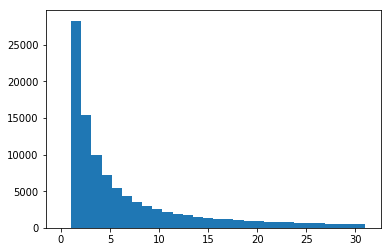

In [291]:
depths = [int(example[-1]) for example in examples]
plt.hist(depths, bins=30, range=(0, MAX_DEPTH+1))
plt.show()

In [292]:
nsamples

defaultdict(int,
            {2: 28278,
             3: 15392,
             4: 9998,
             5: 7154,
             6: 5442,
             7: 4318,
             8: 3534,
             9: 2962,
             10: 2529,
             11: 2192,
             12: 1924,
             13: 1706,
             14: 1526,
             15: 1376,
             16: 1249,
             17: 1141,
             18: 1047,
             19: 965,
             20: 894,
             21: 831,
             22: 775,
             23: 725,
             24: 680,
             25: 639,
             26: 603,
             27: 570,
             28: 539,
             29: 512,
             30: 486})

In [293]:
import random
random.shuffle(examples)
ntrain = int(0.8 * NSAMPLES)
nvalid = int(0.1 * NSAMPLES)
ntest = int(0.1 * NSAMPLES)
train = examples[:ntrain]
valid = examples[ntrain: ntrain+nvalid]
test = examples[ntrain+nvalid:]

In [294]:
for dataset, dataset_type in zip([train, valid, test], ['train', 'valid', 'test']):
    with open('%s_d%d.tsv' % (dataset_type, MAX_DEPTH), 'w') as f:
        for line in dataset:
            f.write('\t'.join(line))
            f.write('\n')

# distribution of sequence length

In [297]:
seq_len = []
for (seq, _, _) in examples:
    seq_len.append(len(seq.split()))

In [298]:
seq, _, _ = examples[0]

In [299]:
len(seq.split())

5

In [300]:
seq

'6 * 6 * 7'

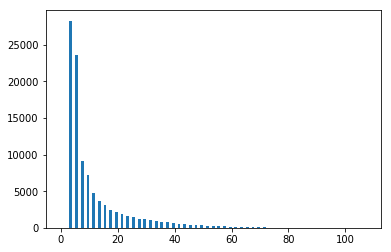

In [302]:
plt.hist(seq_len, bins=max(seq_len), range=(0, max(seq_len)))
plt.show()

# similarity between samples under each depth

In [1]:
examples = {}
with open('test_d30.tsv','r') as f:
    for line in f:
        expr, ds, h = line.strip().split('\t')
        h = int(h)
        if h not in examples:
            examples[h] = []
        examples[h].append((expr, ds))

In [90]:
def ed(s1, s2):
    m=len(s1)+1
    n=len(s2)+1

    tbl = {}
    for i in range(m): tbl[i,0]=i
    for j in range(n): tbl[0,j]=j
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            tbl[i,j] = min(tbl[i, j-1]+1, tbl[i-1, j]+1, tbl[i-1, j-1]+cost)

    return tbl[i,j]

print(ed("Helloworld", "HalloWorld"))

2


In [3]:
h_30 = examples[30]
ds1 = h_30[0][1]
ds2 = h_30[1][1]
print(ds1)
print(ds2)
print(ed(ds1.split(), ds2.split()))

1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 13 14 15 16 17 18 1 2 19 20 1 2 3 4 5 6 21 22 23 24 25 26 1 2 3 4 5 6 27 28 29 30
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 1 2 3 4 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 23 24 1 2 3 4 5 6 7 8 9 10 25 26 27 28 1 2 3 4 29 30 1 2
34


In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def expected_ed(samples, nsampling=1000):
    res = []
    lens = []
    for _ in range(nsampling):
        e1 = random.choice(samples)
        e2 = random.choice(samples)
        edis = ed(e1[1].split(), e2[1].split())
        res.append(edis)
        l1 = len(e1[1].split())
        l2 = len(e2[1].split())
        l_mean = np.mean([l1, l2])
        lens.append(l_mean)
        
    return np.mean(res)/np.mean(lens)

In [52]:
hs = []
expected_eds = []
for h in sorted(examples.keys()):
    hs.append(h)
    expected_eds.append(expected_ed(examples[h]))

In [93]:
def draw(x, y):
    plt.plot(x, y, 'ro-', label='ed/len')
    plt.legend()
    plt.grid()
    plt.grid(color='b' , linewidth=0.1 ,linestyle='--')

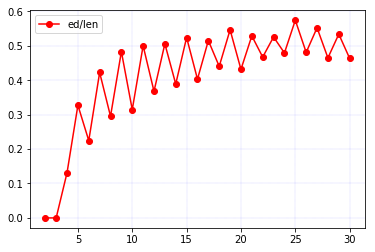

In [53]:
draw(hs, expected_eds)

# re-generate dataset

In [77]:
from collections import defaultdict

MAX_DEPTH = 30
PROB_BRANCH = 0.6
NSAMPLES = 100000
# NSAMPLES = 1000
hs = list(range(2, 11)) + list(range(11, 30, 2))
h2i = {h:i for i, h in enumerate(hs)}
# i2h = dict(list({i:h for i, h in zip(range(11), range(2, 11))}.items()) +\
#     list({i+10:h for i, h in zip(range(10), range(11, 30, 2))}.items()))

In [78]:
h2i

{2: 0,
 3: 1,
 4: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 8,
 11: 9,
 13: 10,
 15: 11,
 17: 12,
 19: 13,
 21: 14,
 23: 15,
 25: 16,
 27: 17,
 29: 18}

In [103]:
prob_h = ((1/np.array(hs))**(1))
prob_h = prob_h / prob_h.sum()
nsamples_bound = {h:int(prob_h[h2i[h]]*NSAMPLES) for h in hs}
nsamples = defaultdict(int)

In [104]:
nsamples_bound

{2: 20181,
 3: 13454,
 4: 10090,
 5: 8072,
 6: 6727,
 7: 5766,
 8: 5045,
 9: 4484,
 10: 4036,
 11: 3669,
 13: 3104,
 15: 2690,
 17: 2374,
 19: 2124,
 21: 1922,
 23: 1754,
 25: 1614,
 27: 1494,
 29: 1391}

In [105]:
examples = []
printed = {h:False for h in hs}
i = 0
while True:
    finished = True
    for h in hs:
        if nsamples[h] < nsamples_bound[h]:
            finished = False
    if finished:
        break
    
    t = gen_tree()
    if t in VALUES:
        continue
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
    if h not in hs:
        continue
    if nsamples[h] >= nsamples_bound[h]:
        if not printed[h]:
            print('finished:', h)
            printed[h] = True
        continue
    else:
        nsamples[h] += 1
    
    sd_lst = ' '.join([str(sd) for sd in sd_lst])
    examples.append((nodes, sd_lst, str(h)))
    i += 1

    if i >= NSAMPLES:
        break

finished: 8
finished: 6
finished: 10
finished: 4
finished: 11
finished: 13
finished: 9
finished: 15
finished: 17
finished: 7
finished: 2
finished: 19
finished: 21
finished: 5
finished: 23
finished: 25
finished: 27
finished: 3


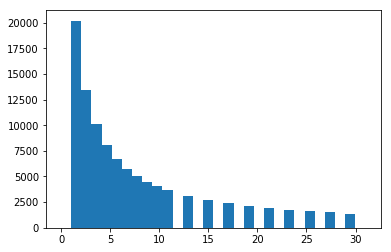

In [106]:
depths = [int(example[-1]) for example in examples]
plt.hist(depths, bins=30, range=(0, MAX_DEPTH+1))
plt.show()

In [88]:
def expected_ed(samples, nsampling=1000):
    res = []
    lens = []
    for _ in range(nsampling):
        e1 = random.choice(samples)
        e2 = random.choice(samples)
        edis = ed(e1[1].split(), e2[1].split())
        res.append(edis)
        l1 = len(e1[1].split())
        l2 = len(e2[1].split())
        l_mean = np.mean([l1, l2])
        lens.append(l_mean)
        
    return np.mean(res)/np.mean(lens)

In [111]:
examples = {}
with open('test_d30.tsv','r') as f:
    for line in f:
        expr, ds, h = line.strip().split('\t')
        h = int(h)
        if h not in examples:
            examples[h] = []
        examples[h].append((expr, ds))
hs = []
expected_eds = []
for h in sorted(examples.keys()):
    hs.append(h)
    expected_eds.append(expected_ed(examples[h]))

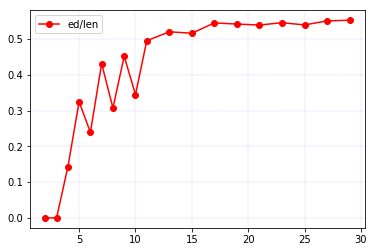

In [112]:
draw(hs, expected_eds)

In [114]:
hs

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [115]:
expected_ed(examples[11])

0.4925398344687799

In [116]:
expected_ed(examples[10])

0.35334139703658907

In [121]:
for e in examples[11]:
    print(e[1])

1 7 1 2 3 4 5 6 8 9 10 11
1 2 3 4 5 6 7 9 1 2 3 4 5 6 7 8 10 11
1 2 3 4 5 6 7 9 1 2 3 4 5 6 7 8 10 11 1 2
1 9 1 2 3 4 5 6 7 8 10 11 1 2 3 4
1 2 3 7 1 2 3 4 5 6 8 9 10 11 1 2
1 9 1 2 3 4 5 6 7 8 10 11
1 2 3 11 1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 1 2 3 4 5 6 9 11 1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 11 1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 9 1 2 3 4 5 6 7 8 10 11
1 2 3 7 1 2 3 4 5 6 8 9 10 11
1 5 1 2 3 4 6 7 8 9 10 11 1 2 3 4
1 2 3 9 1 2 3 4 5 6 7 8 10 11 1 2 3 4 5 6 7 8 9 10
1 7 1 2 3 4 5 6 8 9 10 11
1 5 1 2 3 4 6 7 8 9 10 11 1 2
1 2 3 9 1 2 3 4 5 6 7 8 10 11 1 2
1 7 1 2 3 4 5 6 8 9 1 2 10 11
1 2 3 9 1 2 3 4 5 6 7 8 10 11 1 2 3 4
1 2 3 4 5 6 7 8 1 2 3 4 9 11 1 2 3 4 5 6 7 8 9 10
1 3 1 2 4 5 1 2 6 7 1 2 8 9 10 11 1 2
1 2 3 4 1 2 5 6 1 2 3 4 7 8 1 2 9 11 1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 7 1 2 3 4 5 6 8 9 10 11
1 2 3 4 5 9 1 2 3 4 5 6 7 8 10 11 1 2 3 4 5 6 7 8
1 2 3 11 1 2 3 4 5 6 7 8 9 10
1 11 1 2 3 4 5 6 7 8 9 10
1 2 3 9 1 2 3 4 5 6 7 8 10 11
1 2 3 9 1 2 3 4 5 6 7 8 10 11
1 11 1 2 3 4 5 6 7 8 9 10
1 2

In [120]:
for e in examples[10]:
    print(e[1])

1 2 3 4 1 2 5 6 1 2 7 8 9 10 1 2
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2 3 4
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 1 2 3 4 9 10 1 2
1 2 3 4 5 6 1 2 7 8 9 10
1 2 3 4 5 6 1 2 3 4 7 8 1 2 3 4 5 6 9 10 1 2 3 4
1 2 3 4 5 6 1 2 3 4 7 8 1 2 3 4 9 10 1 2 3 4
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 1 2 7 8 1 2 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2 3 4
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2
1 2 3 4 5 6 7 8 1 2 3 4 5 6 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2 3 4
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 1 2 3 4 7 8 9 10 1 2 3 4
1 2 3 4 5 6 7 8 9 10
1 2 3 4 1 2 5 6 1 2 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 1 2 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10 1 2
1 2 3 4 5 6 7 8 9 10 1 2
1 2 3 4 1 2 5 6 1 2 7 8 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 9 10
1 2 3 4 5 6 7 8 1 2 9 10 1 2
1 2 3 4 5 6 7 8 9 10 1 2 3 4
1 2 3 4 5 6 7 8 9 10
1 2 3 4 1 2 5 6 1 2 7 8 1 2

## save dataset

In [107]:
import random
random.shuffle(examples)
ntrain = int(0.8 * NSAMPLES)
nvalid = int(0.1 * NSAMPLES)
ntest = int(0.1 * NSAMPLES)
train = examples[:ntrain]
valid = examples[ntrain: ntrain+nvalid]
test = examples[ntrain+nvalid:]

In [108]:
for dataset, dataset_type in zip([train, valid, test], ['train', 'valid', 'test']):
    with open('%s_d%d.tsv' % (dataset_type, MAX_DEPTH), 'w') as f:
        for line in dataset:
            f.write('\t'.join(line))
            f.write('\n')

# monotony data

In [69]:
def gen_mono_expr(depth):
    assert depth % 2 == 0
    
    high_priori_done = int(depth * random.random())
    
    res = random.choice(VALUES)
    for i in range(depth):        
        if i % 2 == 0:
            op = random.choice(OPS_E) if i > high_priori_done else random.choice(OPS_T)
            res = (res, OP_MAP[op])
        else:
            num = random.choice(VALUES)
            res = (res, num)
    return res

In [70]:
t = gen_mono_expr(10)
print(t)
to_sd(t)

((((((((((6, '/'), 3), '/'), 1), '*'), 4), '*'), 5), '/'), 2)


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 10)

In [71]:
MAX_DEPTH = 30
PROB_BRANCH = 0.6
NSAMPLES = 30000
# NSAMPLES = 1000
prob_h = (1/np.array(range(2, MAX_DEPTH+1)) )**(1.5)
prob_h = prob_h / prob_h.sum()
nsamples_bound = {h:int(prob_h[h-2]*NSAMPLES) for h in range(2, MAX_DEPTH+1)}
nsamples_bound

{2: 8483,
 3: 4617,
 4: 2999,
 5: 2146,
 6: 1632,
 7: 1295,
 8: 1060,
 9: 888,
 10: 758,
 11: 657,
 12: 577,
 13: 511,
 14: 458,
 15: 413,
 16: 374,
 17: 342,
 18: 314,
 19: 289,
 20: 268,
 21: 249,
 22: 232,
 23: 217,
 24: 204,
 25: 191,
 26: 180,
 27: 171,
 28: 161,
 29: 153,
 30: 146}

In [72]:
with open('test_d30_mono.tsv', 'w') as f:
    for h in nsamples_bound:
        if h % 2 != 0:
            continue
        nh = nsamples_bound[h]
        for i in range(nh):
            t = gen_mono_expr(h)
            nodes = to_nlst(t)
            nodes = ' '.join(nodes)
            sd_lst, h = to_sd(t)
            sd_lst = ' '.join([str(sd) for sd in sd_lst])
            line = (nodes, sd_lst, str(h))
            f.write('\t'.join(line))
            f.write('\n')
                    

# test set that has equal fraction of different depth 

In [119]:
from collections import defaultdict

MAX_DEPTH = 30
PROB_BRANCH = 0.6
NSAMPLES = 20000
# NSAMPLES = 1000
h_keys = list(range(2, 11)) + list(range(11, 30, 2))
h2i = {h:i for i, h in enumerate(h_keys)}

In [106]:
hs

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [107]:
prob_h = np.array([1/len(hs)] * len(hs))
nsamples_bound = {h:int(prob_h[h2i[h]]*NSAMPLES) for h in hs}
nsamples = defaultdict(int)

In [108]:
nsamples_bound

{2: 1052,
 3: 1052,
 4: 1052,
 5: 1052,
 6: 1052,
 7: 1052,
 8: 1052,
 9: 1052,
 10: 1052,
 11: 1052,
 13: 1052,
 15: 1052,
 17: 1052,
 19: 1052,
 21: 1052,
 23: 1052,
 25: 1052,
 27: 1052,
 29: 1052}

In [109]:
examples = []
printed = {h:False for h in hs}
i = 0
while True:
    finished = True
    for h in hs:
        if nsamples[h] < nsamples_bound[h]:
            finished = False
    if finished:
        break
    
    t = gen_tree()
    if t in VALUES:
        continue
        
    nodes = to_nlst(t)
    nodes = ' '.join(nodes)
    sd_lst, h = to_sd(t)
    if h not in hs:
        continue

    if nsamples[h] >= nsamples_bound[h]:
        if not printed[h]:
            print('finished:', h)
            printed[h] = True
        continue
    else:
        nsamples[h] += 1
    
    sd_lst = ' '.join([str(sd) for sd in sd_lst])
    examples.append((nodes, sd_lst, str(h)))
    i += 1

    if i >= NSAMPLES:
        break

finished: 2
finished: 4
finished: 6
finished: 8
finished: 10
finished: 7
finished: 9
finished: 5
finished: 11
finished: 13
finished: 3
finished: 15
finished: 17
finished: 19
finished: 21
finished: 23
finished: 25
finished: 27


In [114]:
def progress_bar(percent, loss, epoch):
    """Prints the progress until the next report."""

    fill = int(percent * 40)
    str_disp = "\r[%s%s]: %.2f/epoch %d" % ('=' * fill,
                                         ' ' * (40 - fill),
                                         percent,
                                         epoch)
    for k, v in loss.items():
        str_disp += ' (%s:%.4f)' % (k, v)

    print(str_disp, end='')

In [113]:
nsamples_bound

{2: 1052,
 3: 1052,
 4: 1052,
 5: 1052,
 6: 1052,
 7: 1052,
 8: 1052,
 9: 1052,
 10: 1052,
 11: 1052,
 13: 1052,
 15: 1052,
 17: 1052,
 19: 1052,
 21: 1052,
 23: 1052,
 25: 1052,
 27: 1052,
 29: 1052}

(array([1052., 1052., 1052., 1052., 1052., 1052., 1052., 1052., 1052.,
        1052., 1052., 1052., 1052., 1052., 1052., 1052., 1052., 1052.,
        1052.]),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 17, 19, 21, 23, 25,
        27, 29, 30]),
 <a list of 19 Patch objects>)

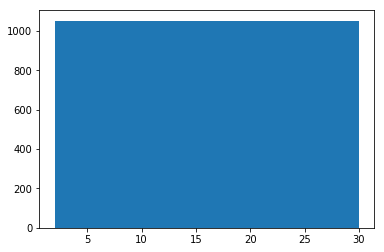

In [123]:
hs = []
for line in examples:
    expr, ds, h = line
    hs.append(int(h))
plt.hist(hs, bins = h_keys + [30])

In [91]:
examples_dict = {}
for line in examples:
    expr, ds, h = line
    h = int(h)
    if h not in examples_dict:
        examples_dict[h] = []
    examples_dict[h].append((expr, ds))
hs = []
expected_eds = []
for h in sorted(examples_dict.keys()):
    hs.append(h)
    expected_eds.append(expected_ed(examples_dict[h]))

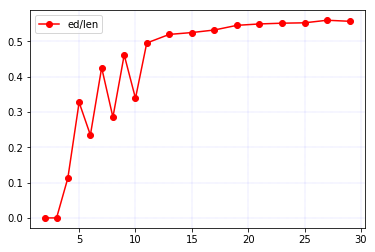

In [94]:
draw(hs, expected_eds)

In [95]:
with open('test_d30_ef.tsv', 'w') as f:
    for line in examples:
        f.write('\t'.join(line))
        f.write('\n')

In [98]:
def num_extrem_vals(ds):
    res = 0
    for i, d in enumerate(ds):
        if i == 0:
            if d > ds[1]:
                res += 1
        elif i == len(ds)-1:
            if d > ds[-2]:
                res += 1
        elif d > ds[i-1] and d > ds[i+1]:
            res += 1
    
    return res            

In [102]:
lines = []
extrems = []
hs = []
with open('test_d30_ef.tsv', 'r') as f:
    for line in f:
        expr, ds, h = line.strip().split('\t')
        hs.append(int(h))
        ds = [int(d) for d in ds.split()]
        extrems.append(num_extrem_vals(ds))
#         lines.append(line)

(array([9780., 3846., 2408., 1549., 1088., 1037.,  181.,   67.,   21.,
          11.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <a list of 10 Patch objects>)

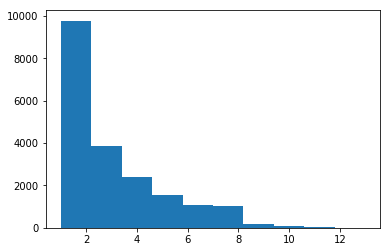

In [101]:
plt.hist(extrems)

(array([3156., 3156., 3156., 1052., 2104., 1052., 1052., 2104., 1052.,
        2104.]),
 array([ 2. ,  4.7,  7.4, 10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. ]),
 <a list of 10 Patch objects>)

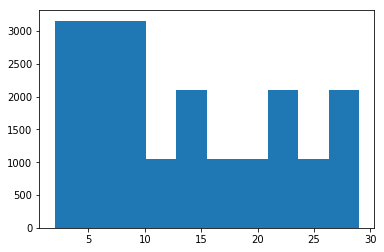

In [103]:
plt.hist(hs)

In [104]:
np.histogram(hs)

(array([3156, 3156, 3156, 1052, 2104, 1052, 1052, 2104, 1052, 2104]),
 array([ 2. ,  4.7,  7.4, 10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. ]))

# \#extremum

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

MAX_DEPTH = 20
PROB_BRANCH = 0.25
VALUES = range(1, 10)
OPS_E = [0, 1]
OPS_T = [2, 3]
NTYPES = ['e', 't']
OP_MAP = ['+', '-', '*', '/']
def num_extrem_vals(ds):
    res = 0
    for i, d in enumerate(ds):
        if i == 0:
            if d > ds[1]:
                res += 1
        elif i == len(ds)-1:
            if d > ds[-2]:
                res += 1
        elif d > ds[i-1] and d > ds[i+1]:
            res += 1
    
    return res            

In [5]:
extremum = []
with open('train_d30.tsv', 'r') as f:
    for line in f:
            expr, ds, h = line.strip().split('\t')
            ds = list(map(int, ds.split()))
            e = num_extrem_vals(ds)
            extremum.append(e)

/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'#extremum')

/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


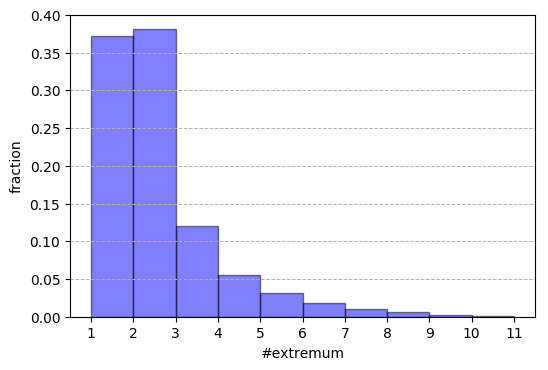

In [35]:
fig, ax = plt.subplots()
fig.dpi = 100
plt.hist(extremum, bins=np.arange(1,12), color='blue', normed=1, alpha=0.5, edgecolor="black")
plt.xticks(np.arange(1, 12))
plt.grid(linewidth=0.7 ,linestyle='--', axis='y')
plt.ylabel('fraction')
plt.xlabel('#extremum')

/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/marc/.pyenv/versions/3.6.4/envs/atec36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


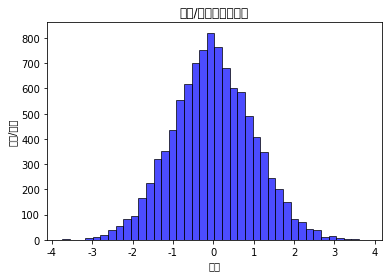

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
# 随机生成（10000,）服从正态分布的数据
data = np.random.randn(10000)
"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
plt.hist(data, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("区间")
# 显示纵轴标签
plt.ylabel("频数/频率")
# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()